In [1]:
!pip install seaborn
!pip install wordcloud
!pip install plotly 
!pip install textstat
!pip install transformers[torch]
!pip install -U datasets
!pip install fsspec==2023.9.2
!pip install accelerate -U
!pip install nltk

# Imports

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade

#### Import model from HF and train it 

##### First model: "distilbert-base-uncased"

In [4]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
from datasets import load_dataset

# Load dataset
dataset = load_dataset('csv', data_files={'train': "./data/train_data_only_text_and_labels.csv", 'eval': "./data/eval_data_only_text_and_labels.csv"})

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text_combined'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/bert',
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'],
)

# Fine-tune the model
trainer.train()


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/l

Epoch,Training Loss,Validation Loss
1,0.041600,0.029742
2,0.012500,0.027271
3,0.002500,0.029378


TrainOutput(global_step=9900, training_loss=0.03066226683782809, metrics={'train_runtime': 2482.7399, 'train_samples_per_second': 63.788, 'train_steps_per_second': 3.988, 'total_flos': 2.097886192515072e+16, 'train_loss': 0.03066226683782809, 'epoch': 3.0})

#### Evaluate results using the test dataset:

In [6]:
# Load the model from the checkpoint
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Path to the saved checkpoint
checkpoint_path = "./results/bert/checkpoint-9900/"

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Load the model from the checkpoint directory
model = DistilBertForSequenceClassification.from_pretrained("./results/bert/checkpoint-9900")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")

In [8]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()

,text_combined,label
0,press release dimitri paris 10 th december new...,1
1,ronan waide waiderwaiderie july 19 kevindated1...,0
2,adminviagracom unable see images email please ...,1
3,tyree puckett rollandduluthmcmahontypepadcom r...,1
4,location reminder wholesale retail power syste...,0


In [9]:
test["text_combined"]

0        press release dimitri paris 10 th december new...
1        ronan waide waiderwaiderie july 19 kevindated1...
2        adminviagracom unable see images email please ...
3        tyree puckett rollandduluthmcmahontypepadcom r...
4        location reminder wholesale retail power syste...
                               ...                        
16493    resume appreciate recommendation van summer in...
16494    conor daly kcwnuskrj_xuidcodhomelinuxorg mon o...
16495    attract opposite sex ultimate guide getting wo...
16496    tim roberts eqemprobocom dick moores wrote 035...
16497    craig berry koumnugralygmailcom 102707 john e ...
Name: text_combined, Length: 16498, dtype: object

In [10]:
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[7880   39]
 [  52 8527]]
Accuracy: 0.994484179900594
Precision: 0.9954471165071211
Recall: 0.9939386874927147
F1-Score: 0.994692330125401
AUC: 0.9997814080998244


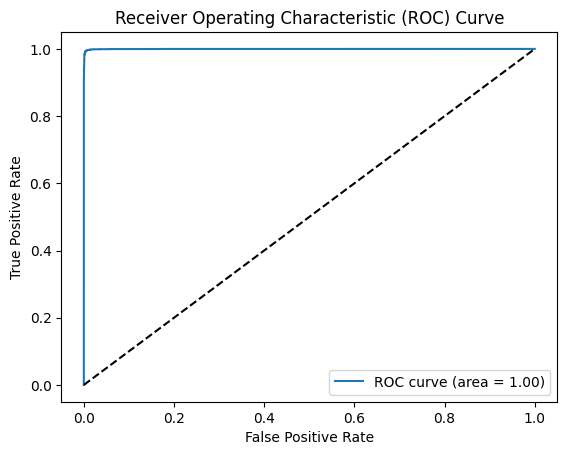

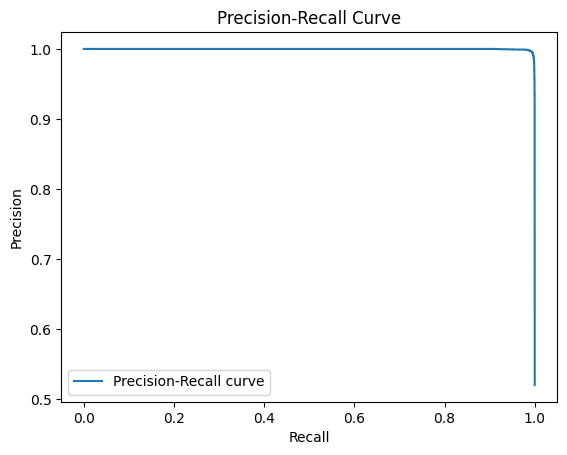

In [11]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Define device
device = torch.device("cpu")  # Change to "cuda" if GPU is available and required

# Move model to device
model.to(device)

# Convert DataFrame column to list of strings
texts = X_test

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}

# Put model in evaluation mode
model.eval()

# Get logits from the model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.cpu()  # Ensure logits are on CPU
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu()  # Ensure probs are on CPU

# Get the predicted labels
predictions = torch.argmax(probs, dim=1).cpu()  # Ensure predictions are on CPU

# Assuming y_true and y_pred are the true and predicted labels respectively
y_true = y_test.values  # True labels (convert to numpy array)
y_pred = predictions.numpy()  # Predicted labels (convert to numpy array)
y_scores = probs[:, 1].numpy()  # Probabilities for the positive class (convert to numpy array)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
print("AUC:", auc)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure()
plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


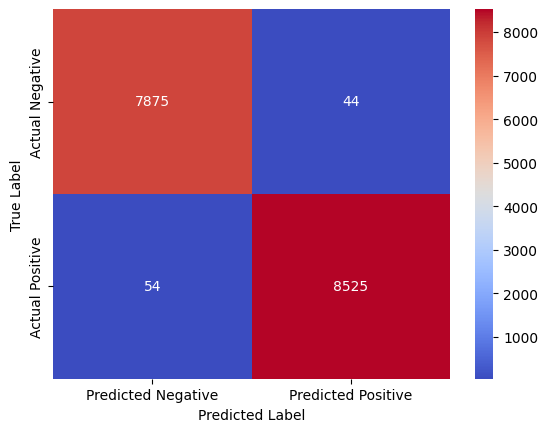

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data matrix
data = np.array([[7875, 44],
                 [54, 8525]])

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()
